# 11-6. 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import cv2
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 10
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


Batch size, Epoch를 16,25 에서 10,20으로 수정했다.

## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train,test, val데이터를 불러온다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


 val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져왔다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상 사진 1070개, 폐렴 사진 3115개의 이미지가 있다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만든다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

num_parallel_calls 파라미터에 AUTOTUNE변수를 이용하면 데이터를 더욱 빠르게 처리한다.
대용량 데이터에 유용할거 같다는 생각이 든다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


train과 val처럼 test도 데이터 처리를 진행한다.

In [14]:


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def aug_prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def gaussian_image(image,laber):
    noise = tf.random.normal(shape = tf.shape(image), mean=0.0, stddev = (50)/(255),
                             dtype=tf.float32)
    noise_img = tf.add(image, noise)
    return noise_img, label

def gauss_prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.map(
            gaussian_image,       
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)  
    
    return ds


train_ds2 = aug_prepare_for_training(train_ds)
val_ds2 = aug_prepare_for_training(val_ds)

train_ds3 = gauss_prepare_for_training(train_ds)
val_ds3 = gauss_prepare_for_training(val_ds)

train_ds1 = prepare_for_training(train_ds)
val_ds1 = prepare_for_training(val_ds)




> - shuffle : r고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.
> - repeat : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데 이때 repeat()을 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해준다.
> - batch : Batch_size에서 정한 만큼의 배치로 주어진다.
> - prefetch : 학습 데이터를 나눠서 읽어오기 때문에 gpu에서 학습하는 동안 두번째 데이터를 cpu에서 준비할수 있어 리소스의 유휴 상태를 줄일 수 있다.

## Step 3. 데이터 시각화

### 3-1. 좌우 반전 하기전 데이터 시각화

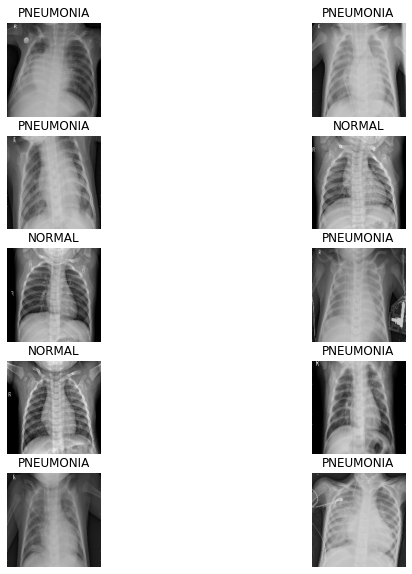

In [70]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch1, label_batch1 = next(iter(train_ds1))
show_batch(image_batch1.numpy(), label_batch1.numpy())

### 3-2. 좌우 반전 후 데이터 시각화

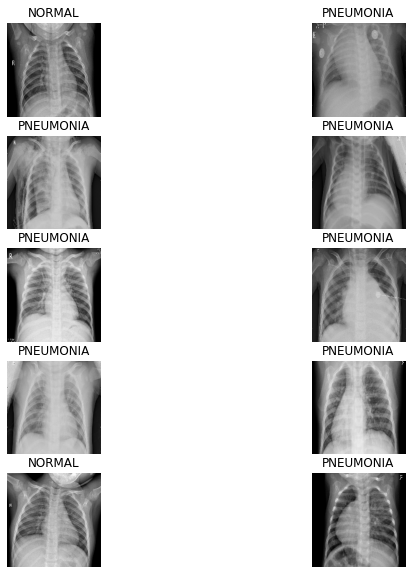

In [71]:
image_batch2, label_batch2 = next(iter(train_ds2))
show_batch(image_batch2.numpy(), label_batch2.numpy())

## Step 4. CNN 모델링

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하지 않기위해
BatchNormalization을 제외했다.

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- Pneumonia 라벨이 너무 많은 경우를 imbalance하다고 표현한다.   
- 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않기 때문에 특정 클래스의 데이터에 더 큰 loss값을 값을 갖도록 자중치를 부여한다.

In [76]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [77]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
418/418 [==============================] - 91s 162ms/step - loss: 0.4417 - accuracy: 0.8174 - precision: 0.8943 - recall: 0.8657 - val_loss: 1.8771 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
418/418 [==============================] - 66s 158ms/step - loss: 0.2260 - accuracy: 0.8992 - precision: 0.9791 - recall: 0.8841 - val_loss: 1.2747 - val_accuracy: 0.3154 - val_precision: 1.0000 - val_recall: 0.0656
Epoch 3/20
418/418 [==============================] - 67s 160ms/step - loss: 0.2214 - accuracy: 0.9051 - precision: 0.9828 - recall: 0.8866 - val_loss: 4.8005 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/20
418/418 [==============================] - 66s 158ms/step - loss: 0.2090 - accuracy: 0.9148 - precision: 0.9811 - recall: 0.9041 - val_loss: 0.1026 - val_accuracy: 0.9683 - val_precision: 0.9692 - val_recall: 0.9882
Epoch 5/20
418/418 [==============================] - 68s 162ms/step - loss: 0.1422 - accura

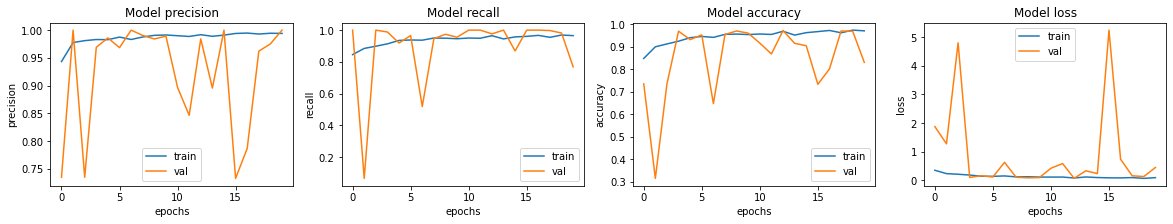

In [78]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [79]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 18s 286ms/step - loss: 0.7510 - accuracy: 0.8157 - precision: 0.8986 - recall: 0.7949
Loss: 0.7509814500808716,
Accuracy: 0.8157051205635071,
Precision: 0.8985507488250732,
Recall: 0.7948718070983887


Batch size, Epoch를 10,20 + BatchNormalization제거 했을때 성능이 떨어졌다.

## Step 5. 가우시안 노이즈 적용

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

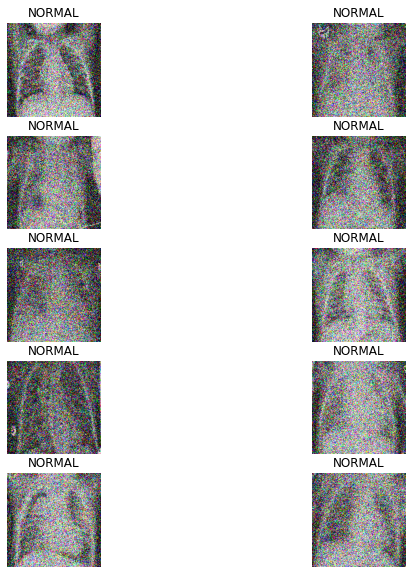

In [153]:
image_batch3, label_batch3 = next(iter(train_ds3))
show_batch(image_batch3.numpy(), label_batch3.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

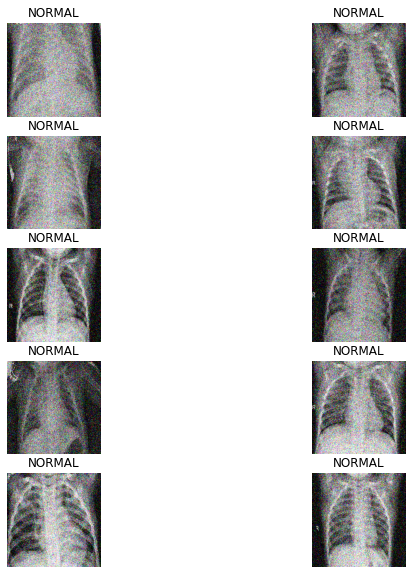

In [155]:
image_batch3, label_batch3 = next(iter(train_ds3))
show_batch(image_batch3.numpy(), label_batch3.numpy())

In [157]:
BATCH_SIZE = 16
EPOCHS = 25

파라미터값들을 원래대로 돌려 놓았다.

In [156]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [159]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 60s 191ms/step - loss: 0.0244 - accuracy: 0.9996 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0279 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 1.9974e-12 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1725 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 2.8231e-06 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5325e-14 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 1.5034e-11 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.3392e-29 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/

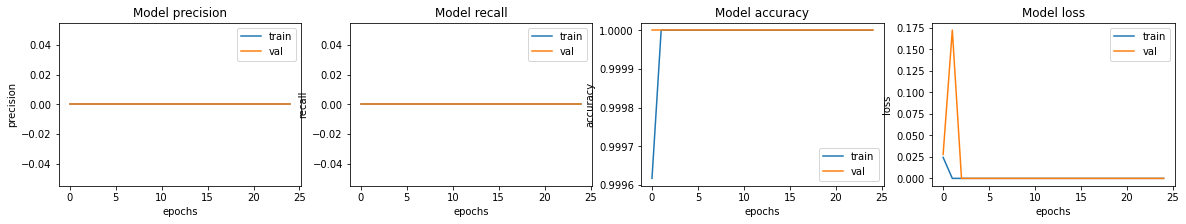

In [160]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [161]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 7s 104ms/step - loss: 191.2518 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 191.2518310546875,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


## Step 6. 하이퍼 파라미터 변경(1)

In [20]:
BATCH_SIZE = 10
EPOCHS = 30

In [19]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
418/418 [==============================] - 90s 149ms/step - loss: 0.5759 - accuracy: 0.7088 - precision: 0.8271 - recall: 0.7732 - val_loss: 0.8053 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/30
418/418 [==============================] - 60s 144ms/step - loss: 0.2629 - accuracy: 0.8900 - precision: 0.9657 - recall: 0.8857 - val_loss: 0.1226 - val_accuracy: 0.9567 - val_precision: 0.9865 - val_recall: 0.9543
Epoch 3/30
418/418 [==============================] - 60s 143ms/step - loss: 0.1927 - accuracy: 0.9206 - precision: 0.9806 - recall: 0.9117 - val_loss: 0.4060 - val_accuracy: 0.8106 - val_precision: 1.0000 - val_recall: 0.7418
Epoch 4/30
418/418 [==============================] - 60s 143ms/step - loss: 0.1366 - accuracy: 0.9474 - precision: 0.9841 - recall: 0.9451 - val_loss: 0.1064 - val_accuracy: 0.9606 - val_precision: 0.9738 - val_recall: 0.9725
Epoch 5/30
418/418 [==============================] - 61s 147ms/step - loss: 0.1359 - accura

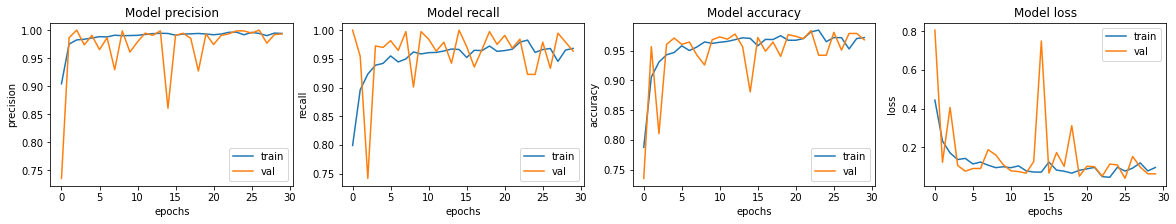

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [23]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 20s 313ms/step - loss: 1.1890 - accuracy: 0.8349 - precision: 0.7996 - recall: 0.9821
Loss: 1.188964605331421,
Accuracy: 0.8349359035491943,
Precision: 0.7995824813842773,
Recall: 0.9820512533187866


## Step 6. 하이퍼 파라미터 변경(2)

In [24]:
BATCH_SIZE = 6
EPOCHS = 40

In [25]:
with tf.device('/GPU:0'):
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
697/697 [==============================] - 104s 134ms/step - loss: 0.4380 - accuracy: 0.7994 - precision: 0.9095 - recall: 0.8168 - val_loss: 0.5590 - val_accuracy: 0.7270 - val_precision: 0.7270 - val_recall: 1.0000
Epoch 2/40
697/697 [==============================] - 93s 134ms/step - loss: 0.2130 - accuracy: 0.9096 - precision: 0.9780 - recall: 0.8987 - val_loss: 0.2041 - val_accuracy: 0.9080 - val_precision: 0.8912 - val_recall: 0.9953
Epoch 3/40
697/697 [==============================] - 94s 135ms/step - loss: 0.1718 - accuracy: 0.9317 - precision: 0.9851 - recall: 0.9221 - val_loss: 1.0874 - val_accuracy: 0.7506 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 4/40
697/697 [==============================] - 95s 136ms/step - loss: 0.1328 - accuracy: 0.9482 - precision: 0.9896 - recall: 0.9403 - val_loss: 0.0758 - val_accuracy: 0.9672 - val_precision: 0.9856 - val_recall: 0.9693
Epoch 5/40
697/697 [==============================] - 96s 137ms/step - loss: 0.1082 - accur

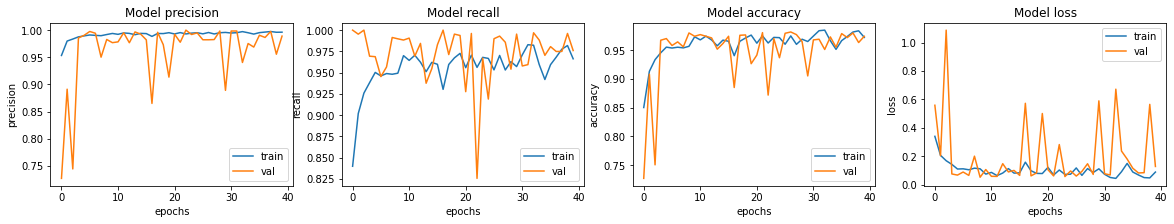

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [28]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 94ms/step - loss: 3.4098 - accuracy: 0.8526 - precision: 0.8184 - recall: 0.9821
Loss: 3.409802198410034,
Accuracy: 0.8525640964508057,
Precision: 0.8183760643005371,
Recall: 0.9820512533187866
